# Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import NASNetLarge, MobileNet
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from keras import models, layers
from keras import optimizers, losses

# Obtain Data & Pre-Process Data

Determine batch size of train and test sets

In [2]:
train_folder = 'Data/images/training_set'
test_folder = 'Data/images/test_set'
classes = ['cats', 'dogs']

train_imgs = []
test_imgs = []

for img_class in classes:
    train_imgs.extend([file for file in os.listdir(train_folder+'/'+img_class) if file.endswith('.jpg')])
    test_imgs.extend([file for file in os.listdir(test_folder+'/'+img_class) if file.endswith('.jpg')])
    
train_batch_size = len(train_imgs)
test_batch_size = len(test_imgs)

print(train_batch_size)
print(test_batch_size)

8000
2000


Generate image data

In [3]:
output_folder = 'Data/image_data'

train_generator = ImageDataGenerator().flow_from_directory(
                        train_folder, target_size=(224, 224), batch_size = train_batch_size)

test_generator = ImageDataGenerator().flow_from_directory(
                        test_folder, target_size=(224, 224), batch_size = test_batch_size) 

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Split image data into image and label variables

In [4]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

# Explore Data

Calculate image data shape

In [5]:
print('Train images shape: ', train_images.shape)
print('Test images shape: ', test_images.shape)

Train images shape:  (8000, 224, 224, 3)
Test images shape:  (2000, 224, 224, 3)


Calculate label data shape

In [6]:
print('Train labels shape: ', train_labels.shape)
print('Test labels shape: ', test_labels.shape)

Train labels shape:  (8000, 2)
Test labels shape:  (2000, 2)


Calculate label class distribution

In [7]:
train_labels_df = pd.DataFrame(train_labels)
test_labels_df = pd.DataFrame(test_labels)
total_labels_df = pd.concat([train_labels_df, test_labels_df], axis=0)


print('Train set class distribution')
print(train_labels_df.mean())

print('Test set class distribution')
print(test_labels_df.mean())

print('Overall class distribution')
print(total_labels_df.mean())

Train set class distribution
0    0.5
1    0.5
dtype: float32
Test set class distribution
0    0.5
1    0.5
dtype: float32
Overall class distribution
0    0.5
1    0.5
dtype: float32


Plot image class distribution

Text(0, 0.5, 'Count')

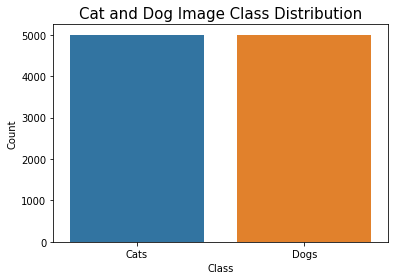

In [8]:
fig, ax = plt.subplots()
sns.countplot(x=0, data=total_labels_df, ax=ax)
ax.set_title('Cat and Dog Image Class Distribution', fontsize=15)
ax.set_xticklabels(['Cats', 'Dogs'])
ax.set_xlabel('Class')
ax.set_ylabel('Count')

# Model data

Build baseline dummy classifier

In [9]:
y_train_dummy = train_labels_df[0]
x_train_dummy = [0]*len(y_train_dummy)
dc = DummyClassifier(strategy='stratified', random_state=84)
dc.fit(x_train_dummy, y_train_dummy)
y_val_pred_dc = dc.predict([0]*len(val_classes))
print('Val Accuracy Score:', accuracy_score(val_classes, y_val_pred_dc))

NameError: name 'val_classes' is not defined

Build NASNetLarge model

In [9]:
pre_model = MobileNet(
    input_shape=train_images.shape[1:],
    include_top=False,
    weights="imagenet")
pre_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

Add custom output layers NASNetLarge to model

In [18]:
output = pre_model.output
output = layers.GlobalAveragePooling2D()(output)
output = layers.Dense(12, activation='relu')(output) 
output = layers.Dense(2, activation='softmax')(output)

model=Model(inputs=pre_model.input,outputs=output)

Make NASNetLarge model layers non-trained

In [19]:
for layer in model.layers[:-3]:
    layer.trainable=False
for layer in model.layers[-3:]:
    layer.trainable=True

Compile and train model

In [20]:
model.compile(optimizer='Adam',loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    batch_size=32,
                    validation_data=(test_images, test_labels),
                    callbacks=[es])

Epoch 1/20
 52/250 [=====>........................] - ETA: 7:00 - loss: 0.7008 - accuracy: 0.5373

KeyboardInterrupt: 